In [1]:
MAX_TIME = 1
INIT_SIZE = 5
DEVICE = "cpu" # "cuda:0"

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '12-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'12-torch_p040025_1min_5init_2023-06-07_19-09-30'

# Chapter 12: Sequential Parameter Optimization
## Hyperparameter Tuning: pytorch wth cifar10 Data

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython                 0.2.16
spotRiver                  0.0.92
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


In [5]:
from tabulate import tabulate
import copy
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from functools import partial

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_values,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
)

from spotPython.torch.traintest import evaluate_cv, evaluate_hold_out
from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values
from spotPython.utils.convert import get_Xy_from_df
from spotPython.utils.init import fun_control_init
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch

warnings.filterwarnings("ignore")

from spotPython.torch.netcifar10 import Net_CIFAR10

In [6]:
print(torch.__version__)
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS device: ", mps_device)

2.0.1
MPS device:  mps


## 0. Initialization of the Empty `fun_control` Dictionary

In [7]:
fun_control = fun_control_init(task="classification")

## 1. Load Data Cifar10 Data

In [8]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [9]:
train, test = load_data()
train.data.shape, test.data.shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [10]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})

## 2. Specification of the Preprocessing Model

In [11]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )
prep_model = None
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

Our implementation is based on the Section "Configurable neural network" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) is used here. `spotPython` implements a class which is similar to the class described in the PyTorch tutorial. The class is called `Net_CIFAR10`  and is implemented in the file `netcifar10.py`. The class is imported here.

Note: In addition to the class Net from the PyTorch tutorial, the class Net_CIFAR10 has additional attributes, namely:

* learning rate (`lr`),
* batchsize (`batch_size`),
* epochs (`epochs`), and
* k_folds (`k_folds`).

Further attributes can be easily added to the class, e.g., `optimizer` or `loss_function`.

In [12]:
core_model = Net_CIFAR10
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

### The `hyper_dict` Hyperparameters for the Selected Algorithm

`spotPython` uses simple `JSON` files for the specification of the hyperparameters. The `JSON` file for the `core_model` is called `torch_hyper_dict.json`. The corresponding entries for the `Net_CIFAR10` class are shown below.

```json
{"Net_CIFAR10":
    {
        "l1": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "l2": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "lr": {
            "type": "float",
            "default": 1e-03,
            "transform": "None",
            "lower": 1e-05,
            "upper": 1e-02},
        "batch_size": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "epochs": {
                "type": "int",
                "default": 3,
                "transform": "transform_power_2_int",
                "lower": 1,
                "upper": 4},
        "k_folds": {
            "type": "int",
            "default": 2,
            "transform": "None",
            "lower": 2,
            "upper": 3}
    }
}
```

Each entry in the `JSON` file represents one hyperparameter with the following structure:
`type`, `default`, `transform`, `lower`, and `upper`.


### Categorical Hyperparameters


In contrast to Ray Tune, `spotPython` can handle numerical, boolean, and categorical hyperparameters. Since `Ray Tune` does not tune categorical hyperparameters, they are not used here. However, they can be specified in the `JSON` file in a similar way as the numerical hyperparameters as shown below:

```json
"factor_hyperparameter": {
    "levels": ["A", "B", "C"],
    "type": "factor",
    "default": "B",
    "transform": "None",
    "core_model_parameter_type": "str",
    "lower": 0,
    "upper": 2},
```

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

After specifying the model, the corresponding hyperparameters, their types and bounds are loaded from the `JSON` file `torch_hyper_dict.json`. After loading, the user can modify the hyperparameters, e.g., the bounds.
`spotPython` provides a clever rule for de-activating hyperparameters. If the lower and the upper bound are set to identical values, the hyperparameter is de-activated. This is useful for the hyperparameter tuning, because it allows to specify a hyperparameter in the `JSON` file, but to de-activate it in the `fun_control` dictionary. This is done in the next step.

### Modify hyperparameter of type numeric and integer (boolean)

Since the hyperparameter `k_folds` is not used in the PyTorch tutorial, it is de-activated here by setting the lower and upper bound to the same value.

In [13]:
# fun_control = modify_hyper_parameter_bounds(fun_control, "delta", bounds=[1e-10, 1e-6])
# fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_split", bounds=[3, 20])
#fun_control = modify_hyper_parameter_bounds(fun_control, "merit_preprune", bounds=[0, 0])
# fun_control["core_model_hyper_dict"]
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[2, 2])

### Modify hyperparameter of type factor

In a similar manner as for the numerical hyperparameters, the categorical hyperparameters can be modified. For example, the hyperparameter `leaf_model` is de-activated here by choosing only one value `"LinearRegression"`.

In [14]:
# fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])
# fun_control["core_model_hyper_dict"]

## 5. Selection of the Objective (Loss) Function

In [15]:
#| echo: true
from torch.nn import CrossEntropyLoss
loss_function = CrossEntropyLoss()
fun_control.update({"loss_function": loss_function})

In addition to the loss functions, `spotPython` provides access to a large number of metrics.

* The key `"metric_sklearn"` is used for metrics that follow the `scikit-learn` conventions.
* The key `"river_metric"` is used for the river based evaluation [@mont20a] via `eval_oml_iter_progressive`, and 
* the key `"metric_torch"` is used for the metrics from `TorchMetrics`. 

`TorchMetrics` is a collection of more than 90 PyTorch metrics^[[https://torchmetrics.readthedocs.io/en/latest/.](https://torchmetrics.readthedocs.io/en/latest/)].

Because the `PyTorch` tutorial uses the accuracy as metric, we use the same metric here. Currently, accuracy is computed in the tutorial's example code. We will use `TorchMetrics` instead, because it offers more flexibilty, e.g., it can be used for regression and classification. Furthermore, `TorchMetrics` offers the following advantages:

* A standardized interface to increase reproducibility
* Reduces Boilerplate
* Distributed-training compatible
* Rigorously tested
* Automatic accumulation over batches
* Automatic synchronization between multiple devices

Therefore, we set 

In [16]:
#| echo: true
import torchmetrics
metric_torch = torchmetrics.Accuracy(task="multiclass", num_classes=10)

**Important**:

* `spotPython` performs minimization by default.
* If accuracy should be maximized, then the objective function has to be multiplied by -1. Therefore, `weights` is set to -1 in this case.

In [17]:
#| echo: true
loss_function = CrossEntropyLoss()
weights = 1.0
metric_torch = torchmetrics.Accuracy(task="multiclass", num_classes=10)
shuffle = True
eval = "train_hold_out"
device = DEVICE
show_batch_interval = 100_000
path="torch_model.pt"

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": None,
               "oml_grace_period": None,
               "weights": weights,
               "step": None,
               "log_level": 50,
               "weight_coeff": None,
               "metric_torch": metric_torch,
               "metric_river": None,
               "metric_sklearn": None,
               "loss_function": loss_function,
               "shuffle": shuffle,
               "eval": eval,
               "device": device,
               "show_batch_interval": show_batch_interval,
               "path": path,
               })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [18]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [19]:
print(gen_design_table(fun_control))

| name         | type   | default   |   lower |   upper | transform             |
|--------------|--------|-----------|---------|---------|-----------------------|
| l1           | int    | 5         |     2   |       9 | transform_power_2_int |
| l2           | int    | 5         |     2   |       9 | transform_power_2_int |
| lr_mult      | float  | 1.0       |     0.1 |      10 | None                  |
| batch_size   | int    | 4         |     1   |       4 | transform_power_2_int |
| epochs       | int    | 3         |     3   |       4 | transform_power_2_int |
| k_folds      | int    | 1         |     2   |       2 | None                  |
| patience     | int    | 5         |     2   |      10 | None                  |
| optimizer    | factor | SGD       |     0   |      12 | None                  |
| sgd_momentum | float  | 0.0       |     0   |       1 | None                  |


The objective function `fun_torch` is selected next. It implements an interface from `PyTorch`'s training, validation, and  testing methods to `spotPython`.

In [20]:
from spotPython.fun.hypertorch import HyperTorch
fun = HyperTorch().fun_torch

### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [21]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[ 5.,  5.,  1.,  4.,  3.,  1.,  5., 11.,  0.]])

In [22]:
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)


config: {'l1': 128, 'l2': 256, 'lr_mult': 3.62368745191023, 'batch_size': 8, 'epochs': 8, 'k_folds': 2, 'patience': 4, 'optimizer': 'Adamax', 'sgd_momentum': 0.5446851204405787}
Epoch: 1
Loss on hold-out set: 1.5280889982938766
Accuracy on hold-out set: 0.44315
MulticlassAccuracy value on hold-out data: 0.44315001368522644
Epoch: 2
Loss on hold-out set: 1.5141336321592331
Accuracy on hold-out set: 0.46225
MulticlassAccuracy value on hold-out data: 0.4622499942779541
Epoch: 3
Loss on hold-out set: 1.3264340688943863
Accuracy on hold-out set: 0.5306
MulticlassAccuracy value on hold-out data: 0.5306000113487244
Epoch: 4
Loss on hold-out set: 1.2851029609322548
Accuracy on hold-out set: 0.5578
MulticlassAccuracy value on hold-out data: 0.5577999949455261
Epoch: 5
Loss on hold-out set: 1.268905950641632
Accuracy on hold-out set: 0.5684
MulticlassAccuracy value on hold-out data: 0.5684000253677368
Epoch: 6
Loss on hold-out set: 1.302527258785069
Accuracy on hold-out set: 0.5749
MulticlassAc

### 4 Results

In [23]:
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

In [24]:
spot_tuner.y

array([1.35492722, 1.28260372, 1.55818474, 2.30569174, 1.25356175])

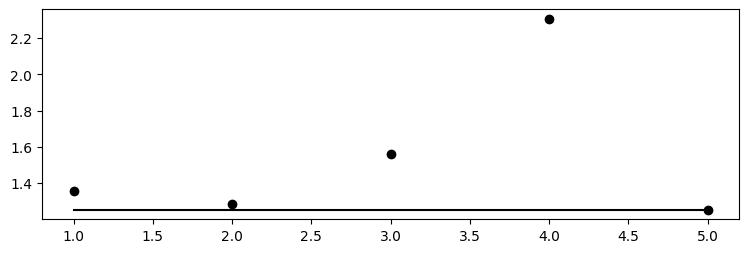

In [25]:
spot_tuner.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")



* Print the Results

In [26]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name         | type   | default   |   lower |   upper |               tuned | transform             |   importance | stars   |
|--------------|--------|-----------|---------|---------|---------------------|-----------------------|--------------|---------|
| l1           | int    | 5         |     2.0 |     9.0 |                 5.0 | transform_power_2_int |       100.00 | ***     |
| l2           | int    | 5         |     2.0 |     9.0 |                 4.0 | transform_power_2_int |         0.05 |         |
| lr_mult      | float  | 1.0       |     0.1 |    10.0 |    6.67491853600136 | None                  |         0.02 |         |
| batch_size   | int    | 4         |     1.0 |     4.0 |                 4.0 | transform_power_2_int |         0.00 |         |
| epochs       | int    | 3         |     3.0 |     4.0 |                 4.0 | transform_power_2_int |         0.00 |         |
| k_folds      | int    | 1         |     2.0 |     2.0 |                 2.0 | None             

## Show variable importance

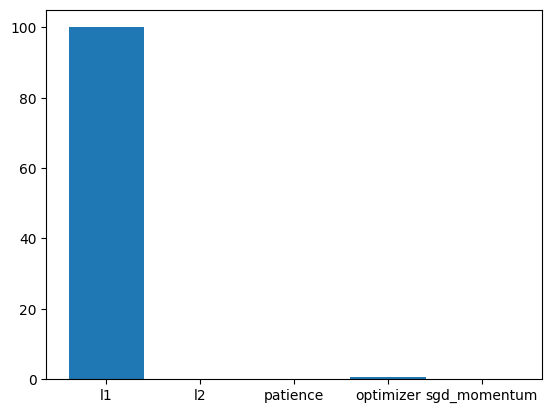

In [27]:
spot_tuner.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

In [28]:
values_default = get_default_values(fun_control)
values_default = transform_hyper_parameter_values(fun_control=fun_control, hyper_parameter_values=values_default)
values_default

{'l1': 32,
 'l2': 32,
 'lr_mult': 1.0,
 'batch_size': 16,
 'epochs': 8,
 'k_folds': 1,
 'patience': 5,
 'optimizer': 'SGD',
 'sgd_momentum': 0.0}

In [29]:
model_default = fun_control["core_model"](**values_default)
model_default

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

## Get SPOT Results {#sec-get-spot-results}

The architecture of the `spotPython` model can be obtained by the following code:

In [30]:
#| echo: true
from spotPython.hyperparameters.values import get_one_core_model_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)

## Evaluation of the Tuned Architecture 

The method `train_tuned` takes a model architecture without trained weights and trains this model with the train data. The train data is split into train and validation data. The validation data is used for early stopping. The trained model weights are saved as a dictionary.

In [ ]:
from spotPython.torch.traintest import (
    train_tuned,
    test_tuned,
    )
train_tuned(net=model_default, train_dataset=train, shuffle=True,
        loss_function=fun_control["loss_function"],
        metric=fun_control["metric_torch"],
        device = DEVICE, show_batch_interval=1_000_000,
        path=None,
        task=fun_control["task"],)

test_tuned(net=model_default, test_dataset=test, 
        loss_function=fun_control["loss_function"],
        metric=fun_control["metric_torch"],
        shuffle=False, 
        device = DEVICE,
        task=fun_control["task"],)

 The following code trains the model `model_spot`. If `path` is set to a filename, e.g., `path = "model_spot_trained.pt"`, the weights of the trained model will be saved to this file.
 If `path` is set to a filename, e.g., `path = "model_spot_trained.pt"`, the weights of the trained model will be loaded from this file.

In [ ]:
#| echo: true
train_tuned(net=model_spot, train_dataset=train,
        loss_function=fun_control["loss_function"],
        metric=fun_control["metric_torch"],
        shuffle=True,
        device = DEVICE,
        path=None,
        task=fun_control["task"],)
#| echo: true
test_tuned(net=model_spot, test_dataset=test,
            shuffle=False,
            loss_function=fun_control["loss_function"],
            metric=fun_control["metric_torch"],
            device = DEVICE,
            task=fun_control["task"],)

## Detailed Hyperparameter Plots

l1:  99.99999999999999
l2:  0.04905952033381626
patience:  0.030760284681762826
optimizer:  0.4703795796088573
sgd_momentum:  0.1181444615954951


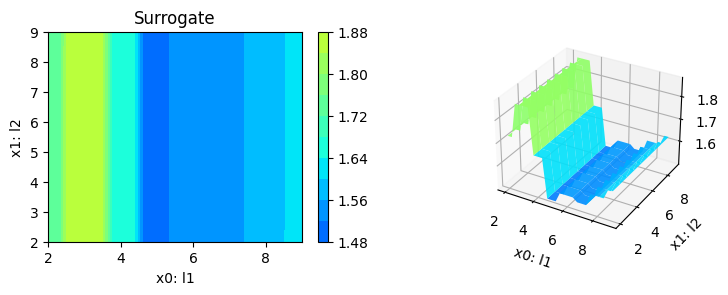

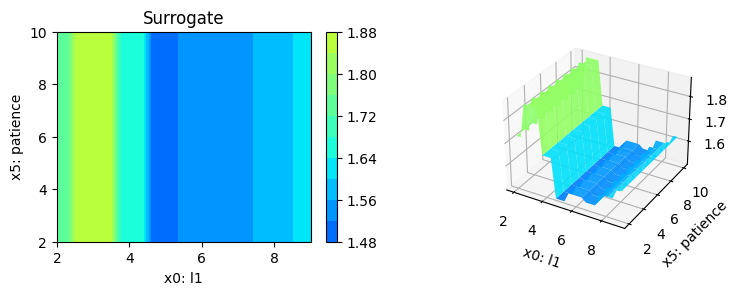

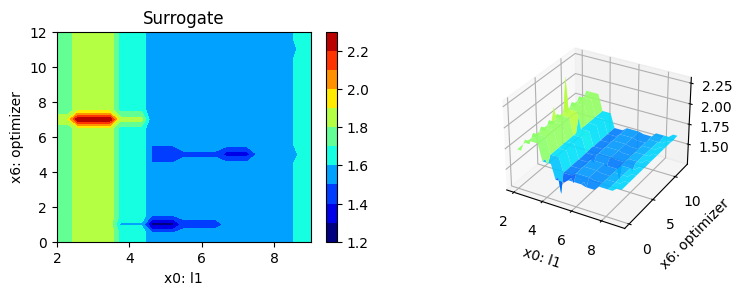

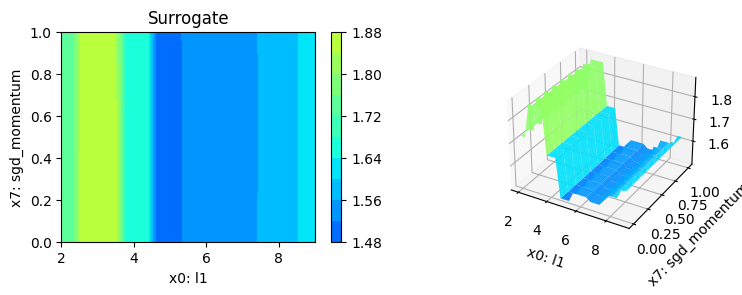

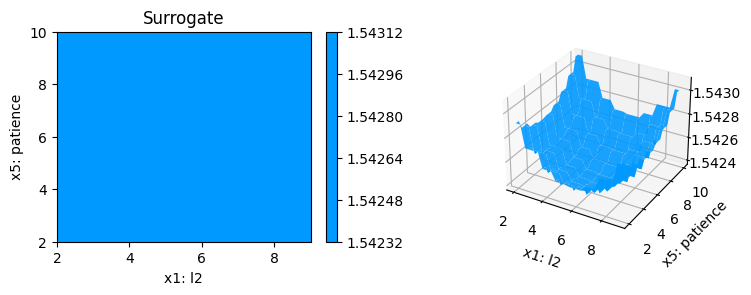

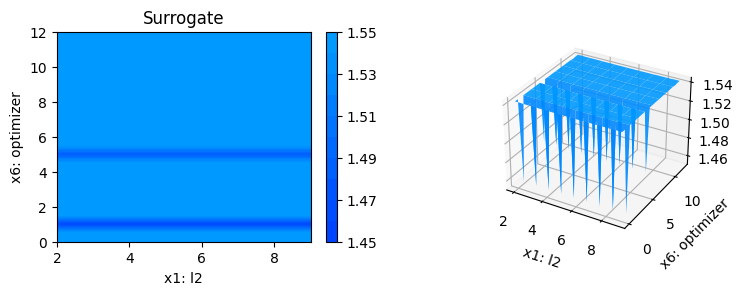

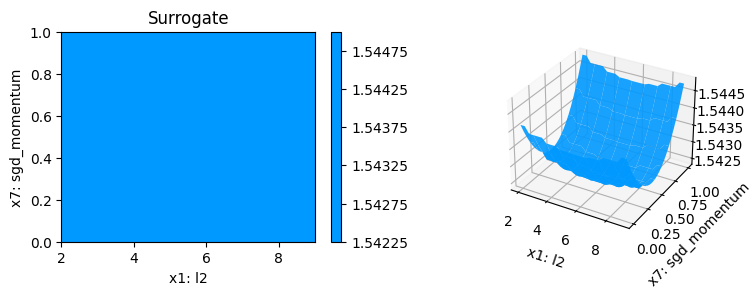

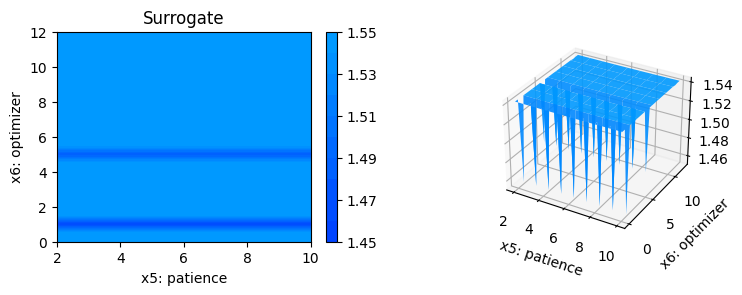

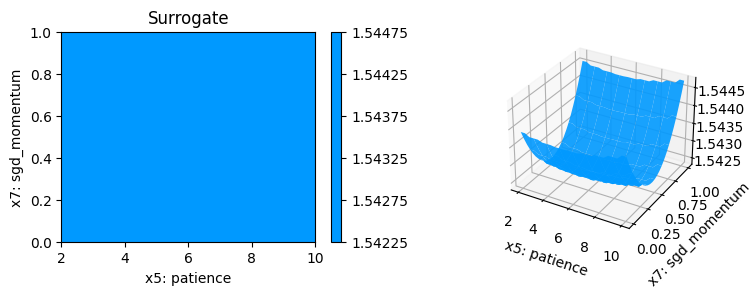

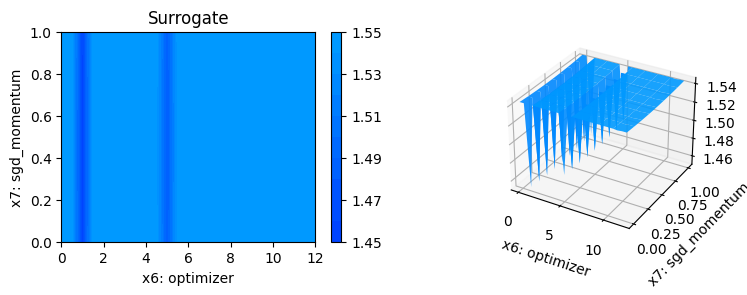

In [31]:
#| echo: true
filename = "./figures/" + experiment_name
spot_tuner.plot_important_hyperparameter_contour(filename=filename)

## Parallel Coordinates Plot

In [32]:
spot_tuner.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [33]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)